# Leverage deployment guardrails to update a SageMaker Inference endpoint using canary traffic shifting

SageMaker Studio Kernel: Data Science

# Contents

 - [Introduction](#Introduction)
 - [Setup](#Setup)
 - [Step 1: Create and deploy the pre-trained models](#Step1)
 - [Step 2: Invoke Endpoint](#Step2)
 - [Step 3: Create CloudWatch alarms to monitor Endpoint performance](#Step3)
 - [Step 4: Update Endpoint with deployment configurations- Canary Traffic Shifting](#Step4)
 - [Cleanup](#Clenup)

# Introduction <a id='Introduction'></a>

Deployment guardrails are a set of model deployment options in Amazon SageMaker Inference to update your machine learning models in production. Using the fully managed deployment guardrails, you can control the switch from the current model in production to a new one. Traffic shifting modes, such as canary and linear, give you granular control over the traffic shifting process from your current model to the new one during the course of the update. There are also built-in safeguards such as auto-rollbacks that help you catch issues early and take corrective action before they impact production.

We support blue-green deployment with multiple traffic shifting modes. A traffic shifting mode is a configuration that specifies how endpoint traffic is routed to a new fleet containing your updates. The following traffic shifting modes provide you with different levels of control over the endpoint update process:

* **All-At-Once Traffic Shifting** : shifts all of your endpoint traffic from the blue fleet to the green fleet. Once the traffic has shifted to the green fleet, your pre-specified Amazon CloudWatch alarms begin monitoring the green fleet for a set amount of time (the “baking period”). If no alarms are triggered during the baking period, then the blue fleet is terminated.
* **Canary Traffic Shifting** : lets you shift one small portion of your traffic (a “canary”) to the green fleet and monitor it for a baking period. If the canary succeeds on the green fleet, then the rest of the traffic is shifted from the blue fleet to the green fleet before terminating the blue fleet.
* **Linear Traffic Shifting** : provides even more customization over how many traffic-shifting steps to make and what percentage of traffic to shift for each step. While canary shifting lets you shift traffic in two steps, linear shifting extends this to n number of linearly spaced steps.


The Deployment guardrails for Amazon SageMaker Inference endpoints feature also allows customers to specify conditions/alarms based on Endpoint invocation metrics from CloudWatch to detect model performance regressions and trigger automatic rollback.

In this notebook we'll update endpoint with following deployment configurations:
 * Blue/Green update policy with **Canary traffic shifting option**
 * Configure CloudWatch alarms to monitor model performance and trigger auto-rollback action.
  
To demonstrate Canary deployments and the auto-rollback feature, we will update an Endpoint with an incompatible model version and deploy it as a Canary fleet, taking a small percentage of the traffic. Requests sent to this Canary fleet will result in errors, which will be used to trigger a rollback using pre-specified CloudWatch alarms. Finally, we will also demonstrate a success scenario where no alarms are tripped and the update succeeds. 

This notebook is organized in 4 steps -
* Step 1 creates the models and Endpoint Configurations required for the 3 scenarios - the baseline, the update containing the incompatible model version and the update containing the correct model version. 
* Step 2 invokes the baseline Endpoint prior to the update. 
* Step 3 specifies the CloudWatch alarms used to trigger the rollbacks. 
* Finally in step 4, we update the endpoint to trigger a rollback and demonstrate a successful update. 

# Setup <a id='Setup'></a>

Ensure that you have an updated version of boto3, which includes the latest SageMaker features:

In [ ]:
!pip install -U awscli
!pip install sagemaker

Setup some required imports and basic initial variables:

In [2]:
%matplotlib inline

import time
import os
import boto3
import botocore
import re
import json
from datetime import datetime, timedelta, timezone
from sagemaker import get_execution_role, session
from sagemaker.s3 import S3Downloader, S3Uploader

region = boto3.Session().region_name

# You can use a different IAM role with "SageMakerFullAccess" policy for this notebook
#role = get_execution_role()
role = 'arn:aws:iam::976939723775:role/service-role/AmazonSageMaker-ExecutionRole-20210317T133000'

print(f"Execution role: {role}")

sm_session = session.Session(boto3.Session())
sm = boto3.Session().client("sagemaker")
sm_runtime = boto3.Session().client("sagemaker-runtime")

# You can use a different bucket, but make sure the role you chose for this notebook
# has the s3:PutObject permissions. This is the bucket into which the model artifacts will be uploaded
bucket = sm_session.default_bucket()
prefix = "sagemaker/DEMO-Deployment-Guardrails-Canary"

Execution role: arn:aws:iam::976939723775:role/service-role/AmazonSageMaker-ExecutionRole-20210317T133000


Download the Input files and pre-trained model from S3 bucket

In [3]:
!aws s3 cp s3://sagemaker-sample-files/models/xgb-churn/xgb-churn-prediction-model.tar.gz model/
!aws s3 cp s3://sagemaker-sample-files/models/xgb-churn/xgb-churn-prediction-model2.tar.gz model/

!aws s3 cp s3://sagemaker-sample-files/datasets/tabular/xgb-churn/test-dataset.csv test_data/
!aws s3 cp s3://sagemaker-sample-files/datasets/tabular/xgb-churn/test-dataset-input-cols.csv test_data/

download: s3://sagemaker-sample-files/models/xgb-churn/xgb-churn-prediction-model.tar.gz to model/xgb-churn-prediction-model.tar.gz
download: s3://sagemaker-sample-files/models/xgb-churn/xgb-churn-prediction-model2.tar.gz to model/xgb-churn-prediction-model2.tar.gz
download: s3://sagemaker-sample-files/datasets/tabular/xgb-churn/test-dataset.csv to test_data/test-dataset.csv
download: s3://sagemaker-sample-files/datasets/tabular/xgb-churn/test-dataset-input-cols.csv to test_data/test-dataset-input-cols.csv


# Step 1: Create and deploy the models <a id='Step1'></a>

### First, we upload our pre-trained models to Amazon S3
This code uploads two pre-trained XGBoost models that are ready for you to deploy. These models were trained using the [XGB Churn Prediction Notebook](https://github.com/aws/amazon-sagemaker-examples/blob/master/introduction_to_applying_machine_learning/xgboost_customer_churn/xgboost_customer_churn.ipynb) in SageMaker. You can also use your own pre-trained models in this step. If you already have a pretrained model in Amazon S3, you can add it by specifying the s3_key.

The models in this example are used to predict the probability of a mobile customer leaving their current mobile operator. The dataset we use is publicly available and was mentioned in the book [Discovering Knowledge in Data](https://www.amazon.com/dp/0470908742/) by Daniel T. Larose. It is attributed by the author to the University of California Irvine Repository of Machine Learning Datasets.

In [4]:
model_url = S3Uploader.upload(
    local_path="model/xgb-churn-prediction-model.tar.gz",
    desired_s3_uri=f"s3://{bucket}/{prefix}",
)
model_url2 = S3Uploader.upload(
    local_path="model/xgb-churn-prediction-model2.tar.gz",
    desired_s3_uri=f"s3://{bucket}/{prefix}",
)

print(f"Model URI 1: {model_url}")
print(f"Model URI 2: {model_url2}")

Model URI 1: s3://sagemaker-us-west-2-976939723775/sagemaker/DEMO-Deployment-Guardrails-Canary/xgb-churn-prediction-model.tar.gz
Model URI 2: s3://sagemaker-us-west-2-976939723775/sagemaker/DEMO-Deployment-Guardrails-Canary/xgb-churn-prediction-model2.tar.gz


### Next, we create our model definitions
Start with deploying the pre-trained churn prediction models. Here, you create the model objects with the image and model data. The three URIs correspond to the baseline version, the update containing the incompatible version, and the update containing the correct model version. 

In [5]:
from sagemaker import image_uris

image_uri = image_uris.retrieve("xgboost", boto3.Session().region_name, "0.90-1")

# using newer version of XGBoost which is incompatible, in order to simulate model faults
image_uri2 = image_uris.retrieve("xgboost", boto3.Session().region_name, "1.2-1")
image_uri3 = image_uris.retrieve("xgboost", boto3.Session().region_name, "0.90-2")

print(f"Model Image 1: {image_uri}")
print(f"Model Image 2: {image_uri2}")
print(f"Model Image 3: {image_uri3}")

Model Image 1: 246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-xgboost:0.90-1-cpu-py3
Model Image 2: 246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-xgboost:1.2-1
Model Image 3: 246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-xgboost:0.90-2-cpu-py3


In [6]:
model_name = f"DEMO-xgb-churn-pred-{datetime.now():%Y-%m-%d-%H-%M-%S}"
model_name2 = f"DEMO-xgb-churn-pred2-{datetime.now():%Y-%m-%d-%H-%M-%S}"
model_name3 = f"DEMO-xgb-churn-pred3-{datetime.now():%Y-%m-%d-%H-%M-%S}"

print(f"Model Name 1: {model_name}")
print(f"Model Name 2: {model_name2}")
print(f"Model Name 3: {model_name3}")

resp = sm.create_model(
    ModelName=model_name,
    ExecutionRoleArn=role,
    Containers=[{"Image": image_uri, "ModelDataUrl": model_url}],
)
print(f"Created Model: {resp}")

resp = sm.create_model(
    ModelName=model_name2,
    ExecutionRoleArn=role,
    Containers=[{"Image": image_uri2, "ModelDataUrl": model_url2}],
)
print(f"Created Model: {resp}")

resp = sm.create_model(
    ModelName=model_name3,
    ExecutionRoleArn=role,
    Containers=[{"Image": image_uri3, "ModelDataUrl": model_url2}],
)
print(f"Created Model: {resp}")

Model Name 1: DEMO-xgb-churn-pred-2022-07-13-15-38-46
Model Name 2: DEMO-xgb-churn-pred2-2022-07-13-15-38-46
Model Name 3: DEMO-xgb-churn-pred3-2022-07-13-15-38-46
Created Model: {'ModelArn': 'arn:aws:sagemaker:us-west-2:976939723775:model/demo-xgb-churn-pred-2022-07-13-15-38-46', 'ResponseMetadata': {'RequestId': '24f6951a-cbbe-431d-aa12-6721930dbb90', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '24f6951a-cbbe-431d-aa12-6721930dbb90', 'content-type': 'application/x-amz-json-1.1', 'content-length': '101', 'date': 'Wed, 13 Jul 2022 15:38:46 GMT'}, 'RetryAttempts': 0}}
Created Model: {'ModelArn': 'arn:aws:sagemaker:us-west-2:976939723775:model/demo-xgb-churn-pred2-2022-07-13-15-38-46', 'ResponseMetadata': {'RequestId': '91603fea-67ed-44ab-9c90-1b65ec1a430b', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '91603fea-67ed-44ab-9c90-1b65ec1a430b', 'content-type': 'application/x-amz-json-1.1', 'content-length': '102', 'date': 'Wed, 13 Jul 2022 15:38:49 GMT'}, 'Retry

### Create Endpoint Configs

We now create three EndpointConfigs, corresponding to the three Models we created in the previous step. 


In [7]:
ep_config_name = f"DEMO-EpConfig-1-{datetime.now():%Y-%m-%d-%H-%M-%S}"
ep_config_name2 = f"DEMO-EpConfig-2-{datetime.now():%Y-%m-%d-%H-%M-%S}"
ep_config_name3 = f"DEMO-EpConfig-3-{datetime.now():%Y-%m-%d-%H-%M-%S}"

print(f"Endpoint Config 1: {ep_config_name}")
print(f"Endpoint Config 2: {ep_config_name2}")
print(f"Endpoint Config 3: {ep_config_name3}")

resp = sm.create_endpoint_config(
    EndpointConfigName=ep_config_name,
    ProductionVariants=[
        {
            "VariantName": "AllTraffic",
            "ModelName": model_name,
            "InstanceType": "ml.m5.xlarge",
            "InitialInstanceCount": 3,
        }
    ],
)
print(f"Created Endpoint Config: {resp}")
time.sleep(5)

resp = sm.create_endpoint_config(
    EndpointConfigName=ep_config_name2,
    ProductionVariants=[
        {
            "VariantName": "AllTraffic",
            "ModelName": model_name2,
            "InstanceType": "ml.m5.xlarge",
            "InitialInstanceCount": 3,
        }
    ],
)
print(f"Created Endpoint Config: {resp}")
time.sleep(5)

resp = sm.create_endpoint_config(
    EndpointConfigName=ep_config_name3,
    ProductionVariants=[
        {
            "VariantName": "AllTraffic",
            "ModelName": model_name3,
            "InstanceType": "ml.m5.xlarge",
            "InitialInstanceCount": 3,
        }
    ],
)
print(f"Created Endpoint Config: {resp}")
time.sleep(5)

Endpoint Config 1: DEMO-EpConfig-1-2022-07-13-15-39-07
Endpoint Config 2: DEMO-EpConfig-2-2022-07-13-15-39-07
Endpoint Config 3: DEMO-EpConfig-3-2022-07-13-15-39-07
Created Endpoint Config: {'EndpointConfigArn': 'arn:aws:sagemaker:us-west-2:976939723775:endpoint-config/demo-epconfig-1-2022-07-13-15-39-07', 'ResponseMetadata': {'RequestId': '701f27f2-e521-4d36-bfc7-98587e7037b4', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '701f27f2-e521-4d36-bfc7-98587e7037b4', 'content-type': 'application/x-amz-json-1.1', 'content-length': '116', 'date': 'Wed, 13 Jul 2022 15:39:07 GMT'}, 'RetryAttempts': 0}}
Created Endpoint Config: {'EndpointConfigArn': 'arn:aws:sagemaker:us-west-2:976939723775:endpoint-config/demo-epconfig-2-2022-07-13-15-39-07', 'ResponseMetadata': {'RequestId': '729583d2-8d26-432c-a2c3-c638093c050a', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '729583d2-8d26-432c-a2c3-c638093c050a', 'content-type': 'application/x-amz-json-1.1', 'content-length': '116'

### Create Endpoint

Deploy the baseline model to a new SageMaker endpoint:

In [8]:
endpoint_name = f"DEMO-Deployment-Guardrails-Canary-{datetime.now():%Y-%m-%d-%H-%M-%S}"
print(f"Endpoint Name: {endpoint_name}")

resp = sm.create_endpoint(EndpointName=endpoint_name, EndpointConfigName=ep_config_name)
print(f"\nCreated Endpoint: {resp}")

Endpoint Name: DEMO-Deployment-Guardrails-Canary-2022-07-13-15-39-42

Created Endpoint: {'EndpointArn': 'arn:aws:sagemaker:us-west-2:976939723775:endpoint/demo-deployment-guardrails-canary-2022-07-13-15-39-42', 'ResponseMetadata': {'RequestId': '0b88b2a9-6bee-4d2f-9323-e1107767c07d', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '0b88b2a9-6bee-4d2f-9323-e1107767c07d', 'content-type': 'application/x-amz-json-1.1', 'content-length': '121', 'date': 'Wed, 13 Jul 2022 15:39:41 GMT'}, 'RetryAttempts': 0}}


Wait for the endpoint creation to complete.

In [9]:
def wait_for_endpoint_in_service(endpoint_name):
    print("Waiting for endpoint in service")
    while True:
        details = sm.describe_endpoint(EndpointName=endpoint_name)
        status = details["EndpointStatus"]
        if status in ["InService", "Failed"]:
            print("\nDone!")
            break
        print(".", end="", flush=True)
        time.sleep(30)


wait_for_endpoint_in_service(endpoint_name)

sm.describe_endpoint(EndpointName=endpoint_name)

Waiting for endpoint in service
....
Done!


{'EndpointName': 'DEMO-Deployment-Guardrails-Canary-2022-07-13-15-39-42',
 'EndpointArn': 'arn:aws:sagemaker:us-west-2:976939723775:endpoint/demo-deployment-guardrails-canary-2022-07-13-15-39-42',
 'EndpointConfigName': 'DEMO-EpConfig-1-2022-07-13-15-39-07',
 'ProductionVariants': [{'VariantName': 'AllTraffic',
   'DeployedImages': [{'SpecifiedImage': '246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-xgboost:0.90-1-cpu-py3',
     'ResolvedImage': '246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-xgboost@sha256:4814427c3e0a6cf99e637704da3ada04219ac7cd5727ff62284153761d36d7d3',
     'ResolutionTime': datetime.datetime(2022, 7, 13, 15, 39, 43, 283000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 3,
   'DesiredInstanceCount': 3}],
 'EndpointStatus': 'InService',
 'CreationTime': datetime.datetime(2022, 7, 13, 15, 39, 42, 306000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2022, 7, 13, 15, 41, 52, 84000, tzinfo=t

# Step 2: Invoke Endpoint <a id='Step2'></a>

You can now send data to this endpoint to get inferences in real time.

This step invokes the endpoint with included sample data with maximum invocations count and waiting intervals. 

In [10]:
def invoke_endpoint(
    endpoint_name, max_invocations=600, wait_interval_sec=1, should_raise_exp=False
):
    print(f"Sending test traffic to the endpoint {endpoint_name}. \nPlease wait...")

    count = 0
    with open("test_data/test-dataset-input-cols.csv", "r") as f:
        for row in f:
            payload = row.rstrip("\n")
            try:
                response = sm_runtime.invoke_endpoint(
                    EndpointName=endpoint_name, ContentType="text/csv", Body=payload
                )
                response["Body"].read()
                print(".", end="", flush=True)
            except Exception as e:
                print("E", end="", flush=True)
                if should_raise_exp:
                    raise e
            count += 1
            if count > max_invocations:
                break
            time.sleep(wait_interval_sec)

    print("\nDone!")


invoke_endpoint(endpoint_name, max_invocations=100)

Sending test traffic to the endpoint DEMO-Deployment-Guardrails-Canary-2022-07-13-15-39-42. 
Please wait...
.....................................................................................................
Done!


### Invocations Metrics

Amazon SageMaker emits metrics such as Latency and Invocations per variant/Endpoint Config (full list of metrics [here](https://docs.aws.amazon.com/sagemaker/latest/dg/monitoring-cloudwatch.html)) in Amazon CloudWatch.

Query CloudWatch to get number of Invocations and latency metrics per variant and endpoint configuration.

In [11]:
import pandas as pd

cw = boto3.Session().client("cloudwatch", region_name=region)


def get_sagemaker_metrics(
    endpoint_name,
    endpoint_config_name,
    variant_name,
    metric_name,
    statistic,
    start_time,
    end_time,
):
    dimensions = [
        {"Name": "EndpointName", "Value": endpoint_name},
        {"Name": "VariantName", "Value": variant_name},
    ]
    if endpoint_config_name is not None:
        dimensions.append({"Name": "EndpointConfigName", "Value": endpoint_config_name})
    metrics = cw.get_metric_statistics(
        Namespace="AWS/SageMaker",
        MetricName=metric_name,
        StartTime=start_time,
        EndTime=end_time,
        Period=60,
        Statistics=[statistic],
        Dimensions=dimensions,
    )
    rename = endpoint_config_name if endpoint_config_name is not None else "ALL"
    if len(metrics["Datapoints"]) == 0:
        return
    return (
        pd.DataFrame(metrics["Datapoints"])
        .sort_values("Timestamp")
        .set_index("Timestamp")
        .drop(["Unit"], axis=1)
        .rename(columns={statistic: rename})
    )


def plot_endpoint_invocation_metrics(
    endpoint_name,
    endpoint_config_name,
    variant_name,
    metric_name,
    statistic,
    start_time=None,
):
    start_time = start_time or datetime.now(timezone.utc) - timedelta(minutes=60)
    end_time = datetime.now(timezone.utc)
    metrics_variants = get_sagemaker_metrics(
        endpoint_name,
        endpoint_config_name,
        variant_name,
        metric_name,
        statistic,
        start_time,
        end_time,
    )
    if metrics_variants is None:
        return
    metrics_variants.plot(title=f"{metric_name}-{statistic}")
    return metrics_variants

### Plot endpoint invocation metrics:

Below, we are going to plot graphs to show the Invocations,Invocation4XXErrors,Invocation5XXErrors,ModelLatency and OverheadLatency against the Endpoint.

You will observe that there should be a flat line for Invocation4XXErrors and Invocation5XXErrors as we are using the correct model version and configs. Additionally, ModelLatency and OverheadLatency will start decreasing over time.

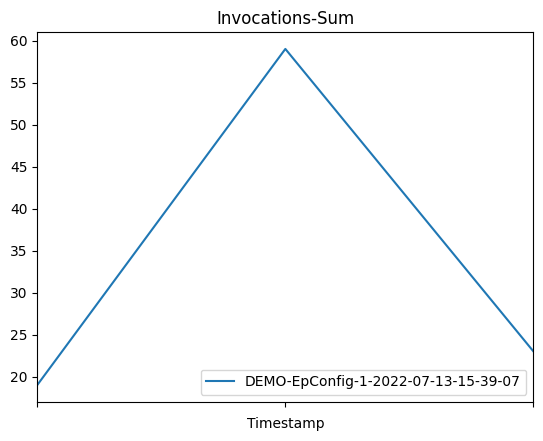

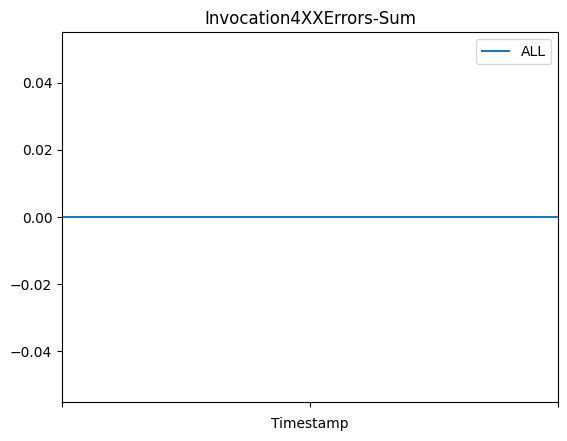

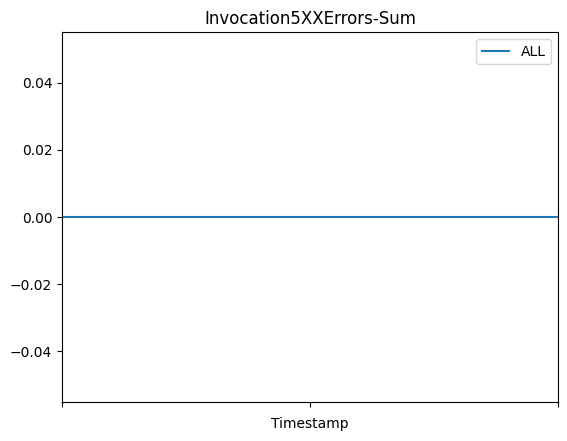

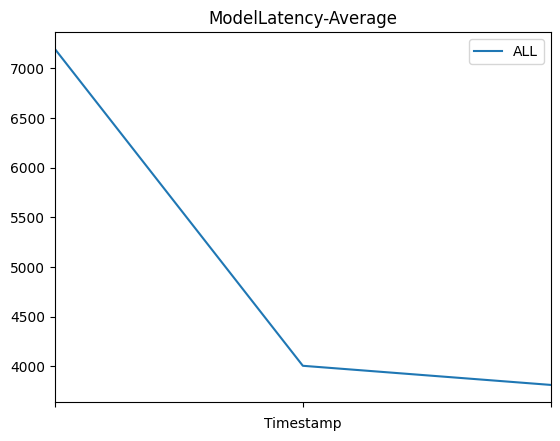

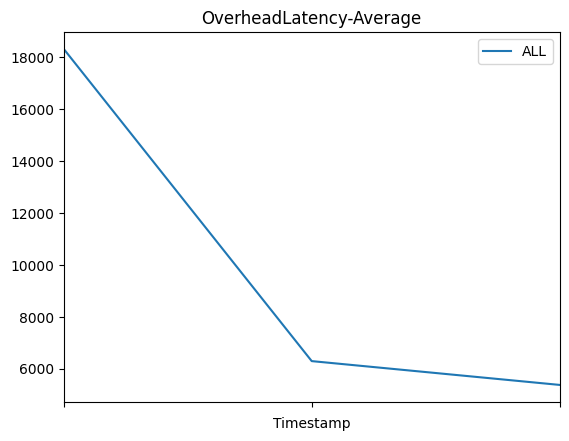

In [12]:
invocation_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, ep_config_name, "AllTraffic", "Invocations", "Sum"
)
invocation_4xx_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "Invocation4XXErrors", "Sum"
)
invocation_5xx_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "Invocation5XXErrors", "Sum"
)
model_latency_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "ModelLatency", "Average"
)
overhead_latency_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "OverheadLatency", "Average"
)

# Step 3: Create CloudWatch alarms to monitor Endpoint performance <a id='Step3'></a>

Create CloudWatch alarms to monitor Endpoint performance with following metrics:
* Invocation5XXErrors
* ModelLatency

Following metric dimensions are used to select the metric per Endpoint config and variant:
* EndpointName
* VariantName


In [13]:
def create_auto_rollback_alarm(
    alarm_name, endpoint_name, variant_name, metric_name, statistic, threshold
):
    cw.put_metric_alarm(
        AlarmName=alarm_name,
        AlarmDescription="Test SageMaker endpoint deployment auto-rollback alarm",
        ActionsEnabled=False,
        Namespace="AWS/SageMaker",
        MetricName=metric_name,
        Statistic=statistic,
        Dimensions=[
            {"Name": "EndpointName", "Value": endpoint_name},
            {"Name": "VariantName", "Value": variant_name},
        ],
        Period=60,
        EvaluationPeriods=1,
        Threshold=threshold,
        ComparisonOperator="GreaterThanOrEqualToThreshold",
        TreatMissingData="notBreaching",
    )

In [14]:
error_alarm = f"TestAlarm-5XXErrors-{endpoint_name}"
latency_alarm = f"TestAlarm-ModelLatency-{endpoint_name}"

# alarm on 1% 5xx error rate for 1 minute
create_auto_rollback_alarm(
    error_alarm, endpoint_name, "AllTraffic", "Invocation5XXErrors", "Average", 1
)
# alarm on model latency >= 10 ms for 1 minute
create_auto_rollback_alarm(
    latency_alarm, endpoint_name, "AllTraffic", "ModelLatency", "Average", 10000
)

In [15]:
cw.describe_alarms(AlarmNames=[error_alarm, latency_alarm])
time.sleep(60)

# Step 4: Update Endpoint with deployment configurations <a id='Step4'></a>

Update the endpoint with deployment configurations and monitor the performance from CloudWatch metrics.


### BlueGreen update policy with Canary traffic shifting

We define the following deployment configuration to perform Blue/Green update strategy with Canary traffic shifting from old to new stack. The Canary traffic shifting option can reduce the blast ratio of a regressive update to the endpoint. In contrast, for the All-At-Once traffic shifting option, the invocation requests start failing at 100% after flipping the traffic. In the Canary mode, invocation requests are shifted to the new version of model gradually, preventing errors from impacting 100% of your traffic. Additionally, the auto-rollback alarms monitor the metrics during the canary stage.

### Rollback Case 
![Rollback case](images/scenario-canary-rollback.png)

Update the Endpoint with an incompatible model version to simulate errors and trigger a rollback.

In [16]:
canary_deployment_config = {
    "BlueGreenUpdatePolicy": {
        "TrafficRoutingConfiguration": {
            "Type": "CANARY",
            "CanarySize": {
                "Type": "INSTANCE_COUNT",  # or use "CAPACITY_PERCENT" as 30%, 50%
                "Value": 1,
            },
            "WaitIntervalInSeconds": 300,  # wait for 5 minutes before enabling traffic on the rest of fleet
        },
        "TerminationWaitInSeconds": 120,  # wait for 2 minutes before terminating the old stack
        "MaximumExecutionTimeoutInSeconds": 1800,  # maximum timeout for deployment
    },
    "AutoRollbackConfiguration": {
        "Alarms": [{"AlarmName": error_alarm}, {"AlarmName": latency_alarm}],
    },
}

# update endpoint request with new DeploymentConfig parameter
sm.update_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=ep_config_name2,
    DeploymentConfig=canary_deployment_config,
)

{'EndpointArn': 'arn:aws:sagemaker:us-west-2:976939723775:endpoint/demo-deployment-guardrails-canary-2022-07-13-15-39-42',
 'ResponseMetadata': {'RequestId': '5ad6d86d-e5d1-466a-ba95-0f7f6a266d77',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '5ad6d86d-e5d1-466a-ba95-0f7f6a266d77',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '121',
   'date': 'Wed, 13 Jul 2022 15:49:24 GMT'},
  'RetryAttempts': 0}}

In [17]:
sm.describe_endpoint(EndpointName=endpoint_name)

{'EndpointName': 'DEMO-Deployment-Guardrails-Canary-2022-07-13-15-39-42',
 'EndpointArn': 'arn:aws:sagemaker:us-west-2:976939723775:endpoint/demo-deployment-guardrails-canary-2022-07-13-15-39-42',
 'EndpointConfigName': 'DEMO-EpConfig-1-2022-07-13-15-39-07',
 'ProductionVariants': [{'VariantName': 'AllTraffic',
   'DeployedImages': [{'SpecifiedImage': '246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-xgboost:0.90-1-cpu-py3',
     'ResolvedImage': '246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-xgboost@sha256:4814427c3e0a6cf99e637704da3ada04219ac7cd5727ff62284153761d36d7d3',
     'ResolutionTime': datetime.datetime(2022, 7, 13, 15, 39, 43, 283000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 3,
   'DesiredInstanceCount': 3}],
 'EndpointStatus': 'Updating',
 'CreationTime': datetime.datetime(2022, 7, 13, 15, 39, 42, 306000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2022, 7, 13, 15, 49, 28, 889000, tzinfo=t

### We invoke the endpoint during the update operation is in progress.

**Note : Invoke endpoint in this notebook is in single thread mode, to stop the invoke requests please stop the cell execution**

The E's denote the errors generated from the incompatible model version in the canary fleet.

The purpose of the below cell is to simulate errors in the canary fleet. Since the nature of traffic shifting to the canary fleet is probabilistic, you should wait until you start seeing errors. Then, you may proceed to stop the execution of the below cell. If not aborted, cell will run for 600 invocations.

In [18]:
invoke_endpoint(endpoint_name)

Sending test traffic to the endpoint DEMO-Deployment-Guardrails-Canary-2022-07-13-15-39-42. 
Please wait...
..EE..E....E.E..E.EE..E....EE........E..E.EE..................................................................................................................................................................................................................................................................................................
Done!


Wait for the update operation to complete and verify the automatic rollback.

In [24]:
wait_for_endpoint_in_service(endpoint_name)

sm.describe_endpoint(EndpointName=endpoint_name)

Waiting for endpoint in service

Done!


{'EndpointName': 'DEMO-Deployment-Guardrails-Canary-2022-07-13-15-39-42',
 'EndpointArn': 'arn:aws:sagemaker:us-west-2:976939723775:endpoint/demo-deployment-guardrails-canary-2022-07-13-15-39-42',
 'EndpointConfigName': 'DEMO-EpConfig-1-2022-07-13-15-39-07',
 'ProductionVariants': [{'VariantName': 'AllTraffic',
   'DeployedImages': [{'SpecifiedImage': '246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-xgboost:0.90-1-cpu-py3',
     'ResolvedImage': '246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-xgboost@sha256:4814427c3e0a6cf99e637704da3ada04219ac7cd5727ff62284153761d36d7d3',
     'ResolutionTime': datetime.datetime(2022, 7, 13, 15, 39, 43, 283000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 3,
   'DesiredInstanceCount': 3}],
 'EndpointStatus': 'InService',
 'FailureReason': 'One or more configured alarm for automatic rollback deployment is in ALARM state: [TestAlarm-ModelLatency-DEMO-Deployment-Guardrails-Canary-2022-07

Collect the endpoint metrics during the deployment:

Below, we are going to plot graphs to show the Invocations,Invocation5XXErrors and ModelLatency against the Endpoint.

You can expect to see as the new endpoint config-2 (erroneous due to model version) starts getting deployed, it encounters failure and leads to the rollback to endpoint config-1. This can be seen in the graphs below as the Invocation5XXErrors and ModelLatency increases during this rollback phase


In [42]:
plot_endpoint_invocation_metrics(
    endpoint_name, ep_config_name2, "AllTraffic", "Invocations", "Sum"
)

AttributeError: 'NoneType' object has no attribute 'index'

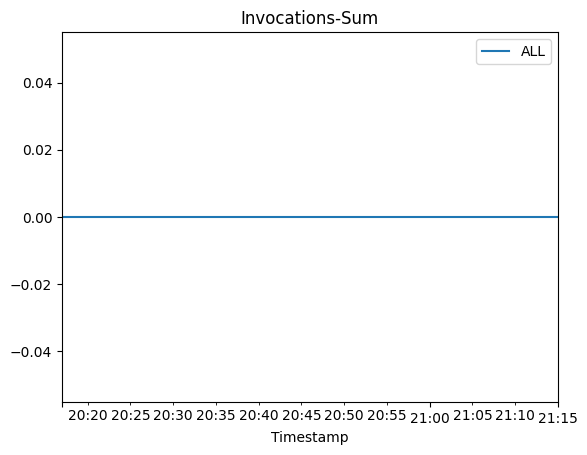

In [20]:
invocation_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "Invocations", "Sum"
)
metrics_epc_1 = plot_endpoint_invocation_metrics(
    endpoint_name, ep_config_name, "AllTraffic", "Invocations", "Sum"
)
metrics_epc_2 = plot_endpoint_invocation_metrics(
    endpoint_name, ep_config_name2, "AllTraffic", "Invocations", "Sum"
)

metrics_all = invocation_metrics.join([metrics_epc_1, metrics_epc_2], how="outer")
metrics_all.plot(title="Invocations-Sum")

invocation_5xx_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "Invocation5XXErrors", "Sum"
)
model_latency_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "ModelLatency", "Average"
)

Let's take a look at the Success case where we use the same Canary deployment configuration but a valid endpoint configuration.

### Success Case
![Success case](images/scenario-canary-success.png)

Now we show the success case where the Endpoint Configuration is updated to a valid version (using the same Canary deployment config as the rollback case).

Update the endpoint with the same Canary deployment configuration:

In [43]:
# update endpoint with a valid version of DeploymentConfig

sm.update_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=ep_config_name3,
    RetainDeploymentConfig=True,
)

{'EndpointArn': 'arn:aws:sagemaker:us-west-2:976939723775:endpoint/demo-deployment-guardrails-canary-2022-07-13-15-39-42',
 'ResponseMetadata': {'RequestId': '3e995270-015c-466a-ba00-8119c10d2998',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '3e995270-015c-466a-ba00-8119c10d2998',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '121',
   'date': 'Wed, 13 Jul 2022 21:33:49 GMT'},
  'RetryAttempts': 0}}

In [44]:
sm.describe_endpoint(EndpointName=endpoint_name)

{'EndpointName': 'DEMO-Deployment-Guardrails-Canary-2022-07-13-15-39-42',
 'EndpointArn': 'arn:aws:sagemaker:us-west-2:976939723775:endpoint/demo-deployment-guardrails-canary-2022-07-13-15-39-42',
 'EndpointConfigName': 'DEMO-EpConfig-1-2022-07-13-15-39-07',
 'ProductionVariants': [{'VariantName': 'AllTraffic',
   'DeployedImages': [{'SpecifiedImage': '246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-xgboost:0.90-1-cpu-py3',
     'ResolvedImage': '246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-xgboost@sha256:4814427c3e0a6cf99e637704da3ada04219ac7cd5727ff62284153761d36d7d3',
     'ResolutionTime': datetime.datetime(2022, 7, 13, 15, 39, 43, 283000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 3,
   'DesiredInstanceCount': 3}],
 'EndpointStatus': 'Updating',
 'FailureReason': 'One or more configured alarm for automatic rollback deployment is in ALARM state: [TestAlarm-ModelLatency-DEMO-Deployment-Guardrails-Canary-2022-07-

Invoke the endpoint during the update operation is in progress:

In [45]:
invoke_endpoint(endpoint_name, max_invocations=500)

Sending test traffic to the endpoint DEMO-Deployment-Guardrails-Canary-2022-07-13-15-39-42. 
Please wait...
..............................................................................................................................................................................................................................................................................................................................................
Done!


Wait for the update operation to complete:

In [ ]:
wait_for_endpoint_in_service(endpoint_name)

sm.describe_endpoint(EndpointName=endpoint_name)

Collect the endpoint metrics during the deployment:

Below, we are going to plot graphs to show the Invocations,Invocation5XXErrors and ModelLatency against the Endpoint.

You can expect to see that, as the new endpoint config-3 (correct model version) starts getting deployed, it takes over endpoint config-2 (incompatible due to model version) without any errors. This can be seen in the graphs below as the Invocation5XXErrors and ModelLatency decreases during this transition phase


In [ ]:
invocation_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "Invocations", "Sum"
)
metrics_epc_1 = plot_endpoint_invocation_metrics(
    endpoint_name, ep_config_name, "AllTraffic", "Invocations", "Sum"
)
metrics_epc_2 = plot_endpoint_invocation_metrics(
    endpoint_name, ep_config_name2, "AllTraffic", "Invocations", "Sum"
)
metrics_epc_3 = plot_endpoint_invocation_metrics(
    endpoint_name, ep_config_name3, "AllTraffic", "Invocations", "Sum"
)

metrics_all = invocation_metrics.join([metrics_epc_1, metrics_epc_2, metrics_epc_3], how="outer")
metrics_all.plot(title="Invocations-Sum")

invocation_5xx_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "Invocation5XXErrors", "Sum"
)
model_latency_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "ModelLatency", "Average"
)

The Amazon CloudWatch metrics for the total invocations for each endpoint config shows how invocation requests are shifted from the old version to the new version during deployment.

You can now safely update your endpoint and monitor model regressions during deployment and trigger auto-rollback action.

# Cleanup <a id='Cleanup'></a>

If you do not plan to use this endpoint further, you should delete the endpoint to avoid incurring additional charges and clean up other resources created in this notebook.

In [ ]:
sm.delete_endpoint(EndpointName=endpoint_name)

In [ ]:
sm.delete_endpoint_config(EndpointConfigName=ep_config_name)
sm.delete_endpoint_config(EndpointConfigName=ep_config_name2)
sm.delete_endpoint_config(EndpointConfigName=ep_config_name3)

In [ ]:
sm.delete_model(ModelName=model_name)
sm.delete_model(ModelName=model_name2)
sm.delete_model(ModelName=model_name3)

In [ ]:
cw.delete_alarms(AlarmNames=[error_alarm, latency_alarm])